# COMP9727 Recommender Systems 25T2 Assignment: 
# Content-Based Music Recommendation

Author: Xianghui Jiang       
zID: z5468921

In [39]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\anaconda3\envs\envpytorch\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     D:\anaconda3\envs\envpytorch\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\anaconda3\envs\envpytorch\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Part 1. Topic Classification 
### Data Loading and Preprocessing

In [3]:
# Loading the dataset
df = pd.read_csv('dataset.tsv', sep='\t')

# Combine all columns into one column 'content'
df['content'] = (df['artist_name'] + ' ' + df['track_name'] + ' ' + df['genre'] + ' ' + df['lyrics'])

# Drop duplicates and missing values
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1480 non-null   object
 1   track_name    1480 non-null   object
 2   release_date  1480 non-null   int64 
 3   genre         1480 non-null   object
 4   lyrics        1480 non-null   object
 5   topic         1480 non-null   object
 6   content       1480 non-null   object
dtypes: int64(1), object(6)
memory usage: 92.5+ KB


In the initial Data Clean, there were 20 duplicates that were removed.

In [4]:
# Text Preprocessing
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk_stop_words = set(stopwords.words('english'))
sklearn_stop_words = set(ENGLISH_STOP_WORDS)

def preprocess_text(text, flag=False, stop_words=nltk_stop_words, method='lemma'):
    text = text.lower()

    if flag:
        # Remove characters other than letters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text)
    else:
        # Remove characters other than letters, numbers, \-!?+=/\.: symbols
        text = re.sub(r"[^\w\s'\-!?+=/\.:]", "", text)
        tokens = word_tokenize(text)
        # Delete single .
        tokens = [token for token in tokens if token != "."]
    
    tokens = [word for word in tokens if word not in stop_words]

    if method == 'stem':
        tokens = [ps.stem(word) for word in tokens]
    elif method == 'lemma':
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

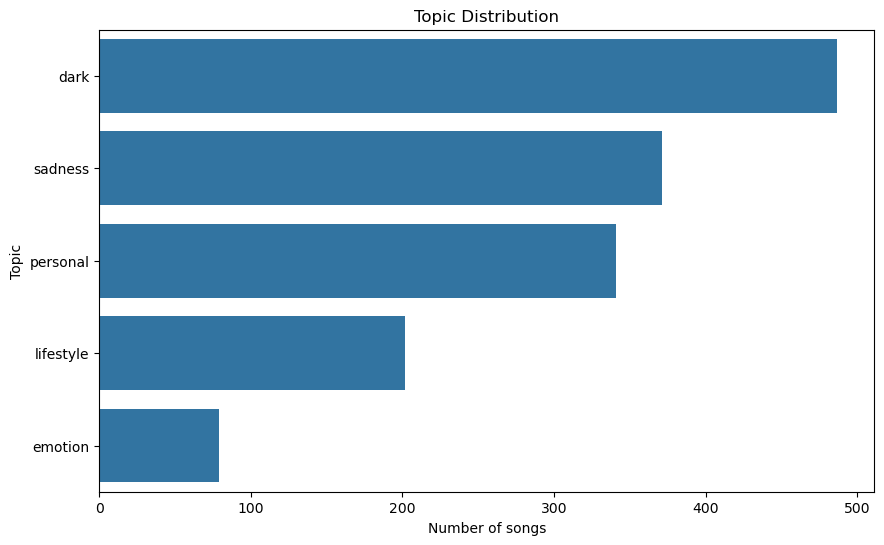


Topic Distribution:
topic
dark         487
sadness      371
personal     341
lifestyle    202
emotion       79
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df['topic'], order=df['topic'].value_counts().index)
plt.title('Topic Distribution')
plt.xlabel('Number of songs')
plt.ylabel('Topic')
plt.show()

print("\nTopic Distribution:")
print(df['topic'].value_counts())

Given the imbalanced nature of the dataset (e.g., the smallest class emotion has only 5.3% (79 samples) of the total samples), relying solely on overall **accuracy** would not give a realistic picture of the model's true performance. Therefore, we selected macro-averaged metrics: **F1-macro**, **precision-macro**, and **recall-macro**, as they treat all classes equally regardless of their frequency.

Among these, F1-macro is chosen as our main evaluation metric because it balances precision and recall across all classes. This is particularly important in imbalanced multi-class classification tasks, where a good model should not only be accurate on majority classes but also avoid neglecting the minority ones.

Precision-macro and recall-macro are also used to provide deeper insight into the model’s trade-off between correctly predicting a class (precision) and covering all true instances of a class (recall).

### Analysis of optimal pre-processing steps

In [6]:
# Define evaluation metrics for cross-validation
scoring_metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']

# Create Bernoulli Naive Bayes (BNB) Pipeline
bnb = Pipeline([('vectorizer', CountVectorizer(binary=True)), ('classifier', BernoulliNB())])

# Create Multinomial Naive Bayes (MNB) Pipeline 
mnb = Pipeline([('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())])

# Use cross-validation to evaluate the performance of the models
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Comparison of Special Character Preprocessing Solutions

Based on the preliminary analysis of the dataset content, I will compare two strategies for handling special characters:

1. **Remove special characters before tokenization**, keeping only letters and numbers.

2. **Perform a lighter cleaning before tokenization**, keeping letters, numbers, and certain special characters (such as **-!?.,+=/**), and then **apply a second cleaning after tokenization** to remove only the single-character token **.** (while keeping ... intact).

In [7]:
y = df['topic']
# First strategy: Remove special characters before tokenization
X = df['content'].apply(lambda x: preprocess_text(x, flag=True))
bnb_scores_1 = cross_validate(bnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
mnb_scores_1 = cross_validate(mnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)


# Second strategy: Perform a lighter cleaning before tokenization and remove . after tokenization
X = df['content'].apply(lambda x: preprocess_text(x, flag=False))
bnb_scores_2 = cross_validate(bnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
mnb_scores_2 = cross_validate(mnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)

In [8]:
def evaluate_and_plot_results(
    bnb_scores_1, mnb_scores_1, bnb_scores_2, mnb_scores_2,
    strategy_labels=('Strategy 1', 'Strategy 2'),
    table_title="BNB vs MNB - Performance Comparison Under Two Preprocessing Strategies:",
    plot_title="BNB vs MNB - F1 Score by Preprocessing Strategy"
):
    """
    Integrate cross-validation results and plot comparative histograms.
    """
    results_df = pd.DataFrame([
        {
            'Strategy': strategy_labels[0],
            'Model': 'BNB',
            'Accuracy': np.mean(bnb_scores_1['test_accuracy']),
            'F1 (Macro)': np.mean(bnb_scores_1['test_f1_macro']),
            'Precision (Macro)': np.mean(bnb_scores_1['test_precision_macro']),
            'Recall (Macro)': np.mean(bnb_scores_1['test_recall_macro']),
        },
        {
            'Strategy': strategy_labels[0],
            'Model': 'MNB',
            'Accuracy': np.mean(mnb_scores_1['test_accuracy']),
            'F1 (Macro)': np.mean(mnb_scores_1['test_f1_macro']),
            'Precision (Macro)': np.mean(mnb_scores_1['test_precision_macro']),
            'Recall (Macro)': np.mean(mnb_scores_1['test_recall_macro']),
        },
        {
            'Strategy': strategy_labels[1],
            'Model': 'BNB',
            'Accuracy': np.mean(bnb_scores_2['test_accuracy']),
            'F1 (Macro)': np.mean(bnb_scores_2['test_f1_macro']),
            'Precision (Macro)': np.mean(bnb_scores_2['test_precision_macro']),
            'Recall (Macro)': np.mean(bnb_scores_2['test_recall_macro']),
        },
        {
            'Strategy': strategy_labels[1],
            'Model': 'MNB',
            'Accuracy': np.mean(mnb_scores_2['test_accuracy']),
            'F1 (Macro)': np.mean(mnb_scores_2['test_f1_macro']),
            'Precision (Macro)': np.mean(mnb_scores_2['test_precision_macro']),
            'Recall (Macro)': np.mean(mnb_scores_2['test_recall_macro']),
        }
    ])

    print("\n" + table_title)
    print(results_df.round(4))

    plt.figure(figsize=(8, 6))
    sns.barplot(data=results_df, x='Model', y='F1 (Macro)', hue='Strategy')
    plt.title(plot_title)
    plt.ylabel("F1 Macro Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


BNB vs MNB - Preprocessing Strategy Comparison
                  Strategy Model  Accuracy  F1 (Macro)  Precision (Macro)  \
0  Clean all special chars   BNB    0.5358      0.3350             0.3510   
1  Clean all special chars   MNB    0.8135      0.7433             0.8291   
2   Keep some + remove dot   BNB    0.5345      0.3343             0.3505   
3   Keep some + remove dot   MNB    0.8128      0.7426             0.8278   

   Recall (Macro)  
0          0.3829  
1          0.7199  
2          0.3819  
3          0.7194  


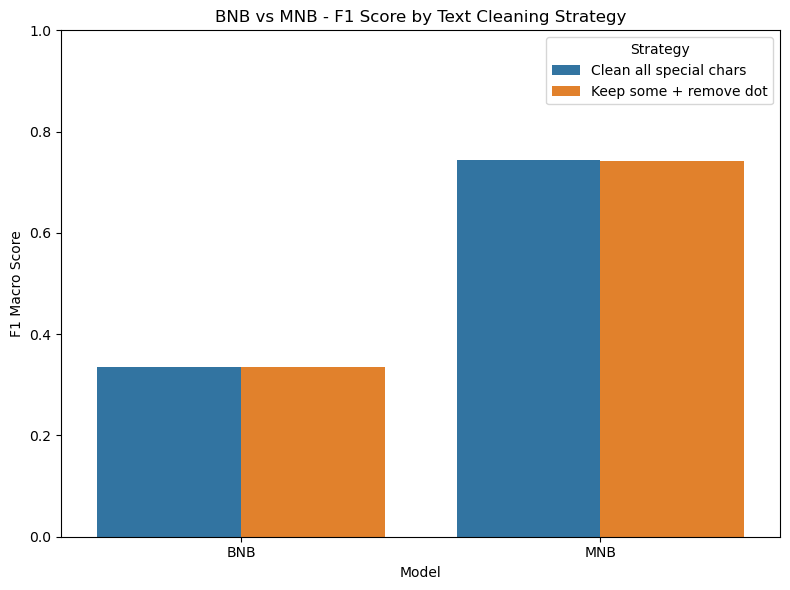

In [9]:
evaluate_and_plot_results(
    bnb_scores_1, mnb_scores_1, bnb_scores_2, mnb_scores_2,
    strategy_labels=('Clean all special chars', 'Keep some + remove dot'),
    table_title="BNB vs MNB - Preprocessing Strategy Comparison",
    plot_title="BNB vs MNB - F1 Score by Text Cleaning Strategy"
)

#### Conclusion
We can see from the results:
For the **BNB** model, the effect of adopting the second strategy is not significantly improved; For the **MNB** model, there is a slight improvement in adopting the second strategy.
For this dataset, the handling of special characters may not have much of an impact. In the following analysis, I will default to the second strategy.

### Evaluation of Different Stop Words

In the following experiment, I will compare the impact of **NLTK** and **Scikit-learn** on the model in terms of handling stop words.

In [10]:
y = df['topic']
# Using nltk stop words
X = df['content'].apply(lambda x: preprocess_text(x, stop_words=nltk_stop_words))
bnb_nltk = cross_validate(bnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
mnb_nltk = cross_validate(mnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)


# Using sklearn stop words
X = df['content'].apply(lambda x: preprocess_text(x, stop_words=sklearn_stop_words))
bnb_sklearn = cross_validate(bnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
mnb_sklearn = cross_validate(mnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)


BNB vs MNB - NLTK vs Sklearn Stopwords
            Strategy Model  Accuracy  F1 (Macro)  Precision (Macro)  \
0     NLTK Stopwords   BNB    0.5345      0.3343             0.3505   
1     NLTK Stopwords   MNB    0.8128      0.7426             0.8278   
2  Sklearn Stopwords   BNB    0.5331      0.3335             0.3489   
3  Sklearn Stopwords   MNB    0.8020      0.7275             0.8077   

   Recall (Macro)  
0          0.3819  
1          0.7194  
2          0.3813  
3          0.7058  


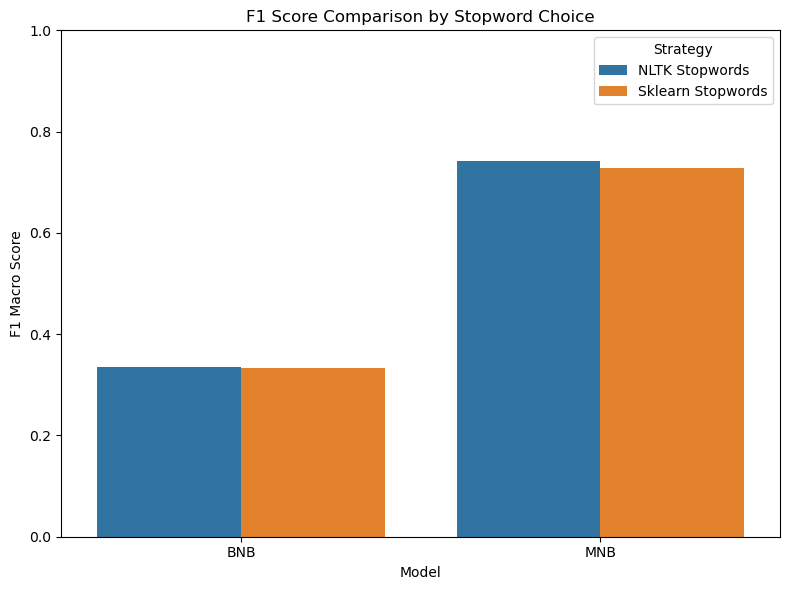

In [11]:
evaluate_and_plot_results(
    bnb_nltk, mnb_nltk, bnb_sklearn, mnb_sklearn,
    strategy_labels=('NLTK Stopwords', 'Sklearn Stopwords'),
    table_title="BNB vs MNB - NLTK vs Sklearn Stopwords",
    plot_title="F1 Score Comparison by Stopword Choice"
)

#### Conclusion
The results show that the choice of stopword list has little to no effect on the **BNB** model, with F1 scores remaining nearly identical under both settings. However, for the **MNB** model, using the NLTK stopword list led to slightly better performance, achieving a higher F1 macro score and recall compared to the Scikit-learn version. 

This difference may be attributed to the richer and more linguistically diverse vocabulary of the **NLTK** stopword list, which is more suitable for informal and expressive texts. In contrast, the **Scikit-learn** list is more concise and optimized for formal written content.

Therefore, I will use the **NLTK** stop words list in the following analysis.

### Comparison of Stemming and Lemmatization

In the following experiment, I will compare the impact of **PorterStemmer** and **Lemmatization** on the model.

In [12]:
y = df['topic']
# Stemming
X = df['content'].apply(lambda x: preprocess_text(x, method='stem'))
bnb_stemmed = cross_validate(bnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
mnb_stemmed = cross_validate(mnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)

# Lemmatization
X = df['content'].apply(lambda x: preprocess_text(x, method='lemma'))
bnb_lemmatized = cross_validate(bnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
mnb_lemmatized = cross_validate(mnb, X, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)


BNB vs MNB - Stemming vs Lemmatization
        Strategy Model  Accuracy  F1 (Macro)  Precision (Macro)  \
0  PorterStemmer   BNB    0.5378      0.3389             0.3496   
1  PorterStemmer   MNB    0.8095      0.7462             0.8283   
2  Lemmatization   BNB    0.5345      0.3343             0.3505   
3  Lemmatization   MNB    0.8128      0.7426             0.8278   

   Recall (Macro)  
0          0.3858  
1          0.7213  
2          0.3819  
3          0.7194  


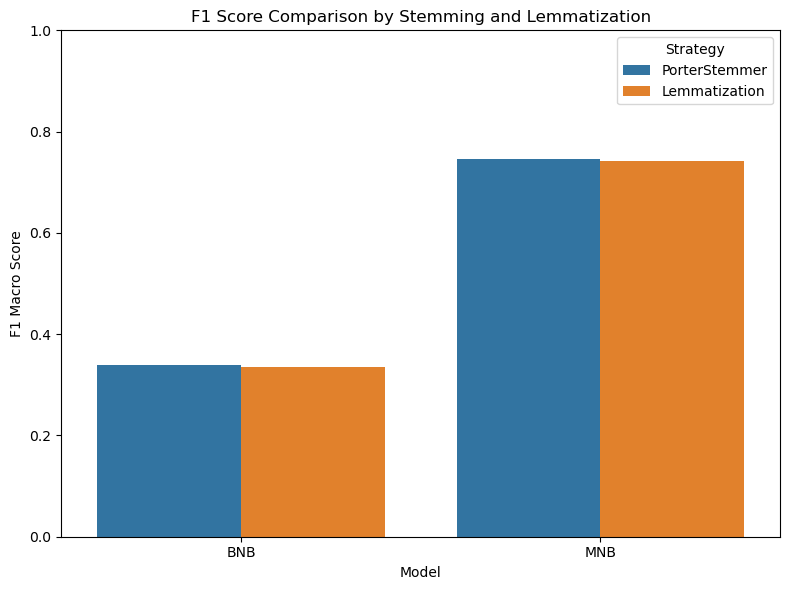

In [13]:
evaluate_and_plot_results(
    bnb_stemmed, mnb_stemmed, bnb_lemmatized, mnb_lemmatized,
    strategy_labels=('PorterStemmer', 'Lemmatization'),
    table_title="BNB vs MNB - Stemming vs Lemmatization",
    plot_title="F1 Score Comparison by Stemming and Lemmatization"
)

#### Conclusion
I compared **Porter Stemming** and **Lemmatization** in text preprocessing. The results show that both methods perform similarly for BNB, with low F1 scores around 0.34. However, for MNB, lemmatization gives slightly better results across accuracy, F1, precision, and recall.

Therefore, I will use the **Lemmatization** in the following analysis.

### Evaluation of Top-N Words in the Vectorizer

In this analysis, I will evaluate the impact of the number of top words on the performance of **BNB** and **MNB** models. I choose the macro **F1 score** as the key score to evaluate, ensuring a robust evaluation across all classes in the context of **Top-N** feature selection.

I will vary the number of top-level words from $1$ to $20,000$ in increments of $1000$, and calculate the average macro F1 score for each model at different Top-N values to determine the optimal number of features for the model.

In [14]:
X = df['content'].apply(preprocess_text)
y = df['topic']
bnb_results = []
mnb_results = []
n_range = range(1, 20000, 1000)

for n in n_range:
    # BNB
    bnb_pipeline = Pipeline([
        ('vectorizer', CountVectorizer(binary=True, max_features=n)),
        ('classifier', BernoulliNB())
    ])
    bnb_scores = cross_validate(bnb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    bnb_results.append({
        'Model': 'BNB',
        'N Features': n,
        'F1 (Macro)': np.mean(bnb_scores['test_score']),
    })

    # MNB
    mnb_pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=n)),
        ('classifier', MultinomialNB())
    ])
    mnb_scores = cross_validate(mnb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    mnb_results.append({
        'Model': 'MNB',
        'N Features': n,
        'F1 (Macro)': np.mean(mnb_scores['test_score']),
    })

df_all = pd.DataFrame(bnb_results + mnb_results)

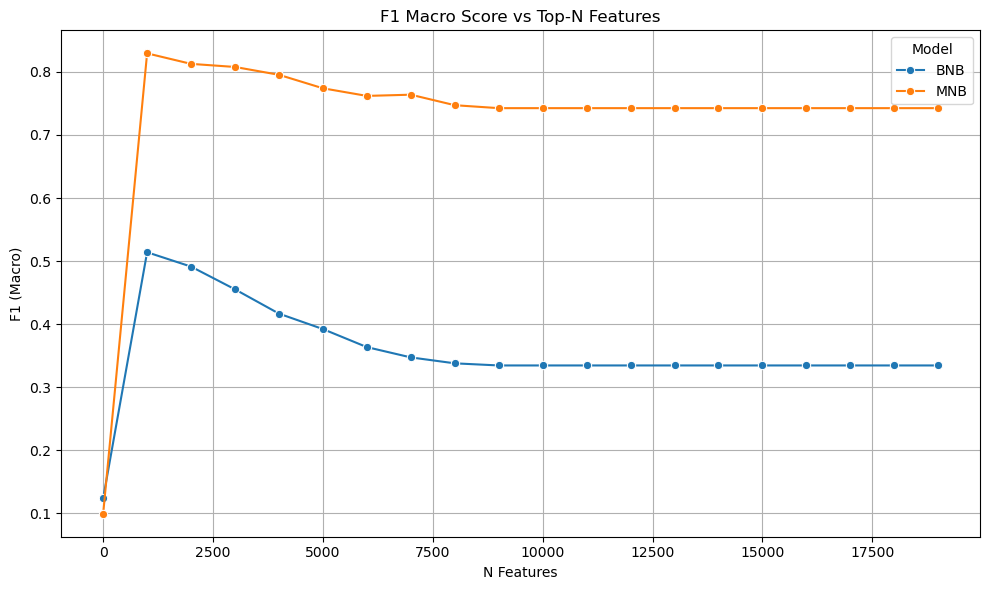

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all, x='N Features', y='F1 (Macro)', hue='Model', marker='o')
plt.title("F1 Macro Score vs Top-N Features")
plt.grid(True)
plt.tight_layout()
plt.show()

According to this plot, it seems that a higher score is obtained when the maximum feature is between $1$ and $2500$. In order to get a more precise indicator within this range, I will perform an additional test in increments of $100$.

In [16]:
bnb_results = []
mnb_results = []
n_range = range(1, 2500, 100)

for n in n_range:
    # BNB
    bnb_pipeline = Pipeline([
        ('vectorizer', CountVectorizer(binary=True, max_features=n)),
        ('classifier', BernoulliNB())
    ])
    bnb_scores = cross_validate(bnb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    bnb_results.append({
        'Model': 'BNB',
        'N Features': n,
        'F1 (Macro)': np.mean(bnb_scores['test_score']),
    })

    # MNB
    mnb_pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=n)),
        ('classifier', MultinomialNB())
    ])
    mnb_scores = cross_validate(mnb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    mnb_results.append({
        'Model': 'MNB',
        'N Features': n,
        'F1 (Macro)': np.mean(mnb_scores['test_score']),
    })

df_all = pd.DataFrame(bnb_results + mnb_results)

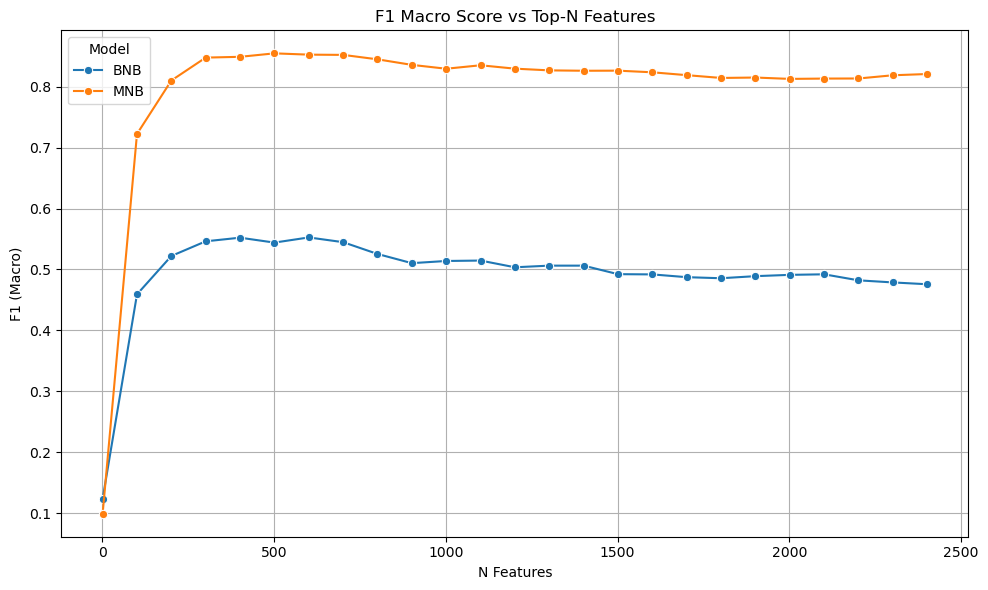

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_all, x='N Features', y='F1 (Macro)', hue='Model', marker='o')
plt.title("F1 Macro Score vs Top-N Features")
plt.grid(True)
plt.tight_layout()
plt.show()


BNB vs MNB at max_features = 500:
  Model  F1 (Macro)
0   BNB      0.5444
1   MNB      0.8548


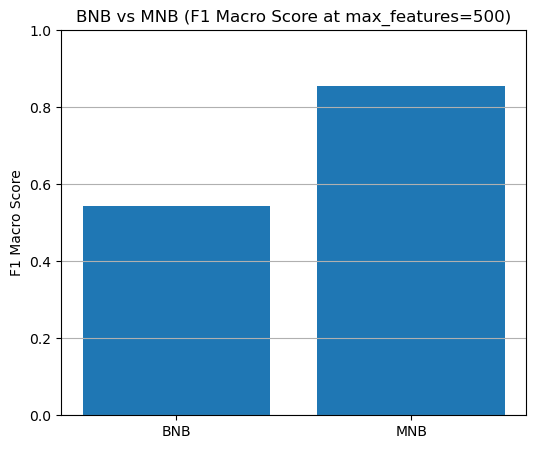

In [18]:
bnb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500, binary=True)),
    ('classifier', BernoulliNB())
])
bnb_scores = cross_validate(bnb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
bnb_f1 = np.mean(bnb_scores['test_score'])

mnb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('classifier', MultinomialNB())
])
mnb_scores = cross_validate(mnb_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
mnb_f1 = np.mean(mnb_scores['test_score'])

results_df = pd.DataFrame([
    {'Model': 'BNB', 'F1 (Macro)': bnb_f1},
    {'Model': 'MNB', 'F1 (Macro)': mnb_f1}
])

print("\nBNB vs MNB at max_features = 500:")
print(results_df.round(4))

plt.figure(figsize=(6, 5))
plt.bar(results_df['Model'], results_df['F1 (Macro)'])
plt.title("BNB vs MNB (F1 Macro Score at max_features=500)")
plt.ylabel("F1 Macro Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

### Conclusion

To determine the optimal number of features (i.e., vocabulary size) for text classification, we conducted a range test using different values of `max_features` in the CountVectorizer, varying from $1$ to $20,000$ in steps of $1,000$ and $1$ to $2500$ in steps of $100$. We evaluated model performance using the **macro F1 score**, which is appropriate for our imbalanced multi-class dataset as it gives equal weight to each class.

The results showed a clear trend: both **BNB** and **MNB** achieved their highest macro F1 scores when the number of features was around 500. After this point, performance plateaued or slightly declined, likely due to the inclusion of sparse or less informative features.

Based on this finding, we selected **500** features as the optimal setting for max_features and used this value consistently in the remaining experiments to balance model performance and complexity.

### Logistic Regression

**Logistic Regression (LR)** is a linear classification model that estimates the probability of a sample belonging to a particular class using the logistic (sigmoid) function. In the multiclass setting, it is commonly implemented with a one-vs-rest strategy. **LR** is especially well-suited for high-dimensional and sparse data, such as bag-of-words (BoW) or TF-IDF representations of text. Since our music dataset consists of short text descriptions (song lyrics, genre tags, etc.), LR is a logical choice as it can capture linear decision boundaries between topics effectively.

In the next analysis, I will use Grid search to adjust the parameters of the LR. Based on the previous conclusions, the `max_features` parameter for the vectorizer will be set to **500**.

In [19]:
X = df['content'].apply(preprocess_text)
y = df['topic']

lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Parameters grid
param_grid = {
    'classifier__C': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_iter': [1000,1500,2000]
}

# Cross Validation Grid Search
grid_search = GridSearchCV(lr_pipeline, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X, y)

# Output optimal parameters and scores
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Macro Score:", round(grid_search.best_score_, 4))

Best Parameters: {'classifier__C': 0.15, 'classifier__class_weight': None, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}
Best F1 Macro Score: 0.8674



BNB vs MNB vs Lr
  Model  F1 (Macro)
0   BNB      0.5444
1   MNB      0.8548
2    Lr      0.8674


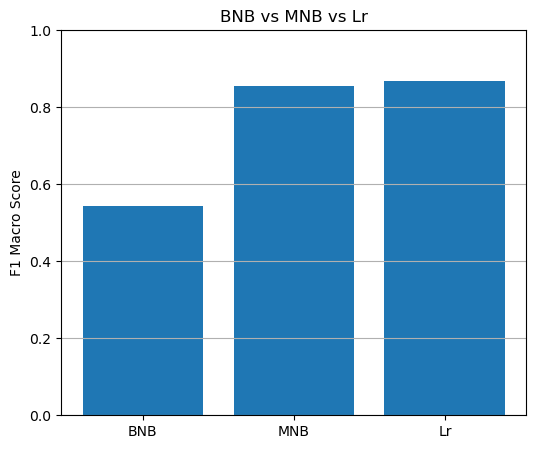

In [20]:
lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('classifier', LogisticRegression(C=0.15, max_iter=1000, penalty='l2', solver='liblinear', random_state=42))
])
lr_scores = cross_validate(lr_pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
lr_f1 = np.mean(lr_scores['test_score'])

results_df = pd.DataFrame([
    {'Model': 'BNB', 'F1 (Macro)': bnb_f1},
    {'Model': 'MNB', 'F1 (Macro)': mnb_f1},
    {'Model': 'Lr', 'F1 (Macro)': lr_f1}
])

print("\nBNB vs MNB vs Lr")
print(results_df.round(4))

plt.figure(figsize=(6, 5))
plt.bar(results_df['Model'], results_df['F1 (Macro)'])
plt.title("BNB vs MNB vs Lr")
plt.ylabel("F1 Macro Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

### Conclusion

The results show that **BNB** performs the worst, likely because it only captures binary presence/absence of words, which loses important frequency information. **MNB** significantly improves performance by considering term frequencies, making it more suitable for text classification tasks. **Logistic Regression (LR)** achieves the best performance overall, slightly outperforming MNB. 

This confirms our hypothesis that LR, with its ability to learn weighted feature contributions and handle correlated features, is better suited for high-dimensional sparse text data.

## Part 2. Recommendation Methods
### Data Loading and Preprocessing

In [21]:
# Data split
train_data = df.iloc[:750].copy()
test_data = df.iloc[750:1000].copy()

# Preprocessing
X_train = train_data['content'].apply(preprocess_text)
y_train = train_data['topic']

### TfidfVectorizer is not as effective as CountVectorizer.
# best_classifier = Pipeline([
#     ('vectorizer', TfidfVectorizer(max_features=400, stop_words='english')),
#     ('classifier', LogisticRegression(C=0.15, max_iter=1000, penalty='l2', 
#                                     solver='liblinear', random_state=42))
# ])

best_classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('classifier', LogisticRegression(C=0.15, max_iter=1000, penalty='l2', 
                                    solver='liblinear', random_state=42))
])

# Classifier training
best_classifier.fit(X_train, y_train)

# Extract fitted vectorizers from Pipeline
vectorizer = best_classifier.named_steps['vectorizer']

With comparative tests, I found that using TfidfVectorizer with the best model parameters is not as effective as CountVectorizer, so in part2 I will continue to follow the parameter settings of part1.

In [22]:
# Read user data
user1_data = pd.read_csv('user1.tsv', sep='\t')
user2_data = pd.read_csv('user2.tsv', sep='\t')

# Convert user data to dictionary format
user1_keywords = {}
for _, row in user1_data.iterrows():
    keywords = [kw.strip() for kw in row['keywords'].split(',')]
    user1_keywords[row['topic']] = keywords

user2_keywords = {}
for _, row in user2_data.iterrows():
    keywords = [kw.strip() for kw in row['keywords'].split(',')]
    user2_keywords[row['topic']] = keywords

print("User 1 keywords:")
for topic, keywords in user1_keywords.items():
    print(f"  {topic}: {keywords}")

print("\nUser 2 keywords:")
for topic, keywords in user2_keywords.items():
    print(f"  {topic}: {keywords}")

User 1 keywords:
  dark: ['fire', 'enemy', 'pain', 'storm', 'fight']
  sadness: ['cry', 'alone', 'heartbroken', 'tears', 'regret']
  personal: ['dream', 'truth', 'life', 'growth', 'identity']
  lifestyle: ['party', 'city', 'night', 'light', 'rhythm']
  emotion: ['love', 'memory', 'hug', 'kiss', 'feel']

User 2 keywords:
  sadness: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']
  emotion: ['romance', 'touch', 'feeling', 'kiss', 'memory']


### Create user profile

In [23]:
# Topic prediction on training set data
train_data['predicted_topic'] = best_classifier.predict(X_train)

def create_user_profile(user_keywords, train_df, vectorizer):
    """
    Create user profiles based on user keywords and topic vectors
    """
    user_topic_profiles = {}
    
    # Iterate through each topic of interest to the user
    for topic, keywords in user_keywords.items():
        
        # a helper function to check for keywords
        def contains_keyword(text, kws):
            return any(kw in text for kw in kws)

        # Apply the filter
        liked_songs_df = train_df[
            (train_df['predicted_topic'] == topic) &
            (train_df['content'].apply(lambda x: contains_keyword(preprocess_text(x), keywords)))
        ]
        
        # Merge song text
        if not liked_songs_df.empty:
            combined_document = ' '.join(liked_songs_df['content'].apply(preprocess_text))
            profile_vector = vectorizer.transform([combined_document])
            user_topic_profiles[topic] = profile_vector
        else:
            # If no matching song is found, the image vector is empty.
            user_topic_profiles[topic] = None
            
    return user_topic_profiles

# Get and print Top 20 keywords
def get_top_words(profile_vector, vectorizer, top_n=20):
    """
    Extract the top-ranked 20 words from a TF-IDF vector
    """
    if profile_vector is None:
        return ["No songs found for this topic."]
    
    # Convert sparse matrix to numpy array
    vec_array = profile_vector.toarray().flatten()
    
    # Gets the index of the sorted word (from high to low)
    top_indices = vec_array.argsort()[::-1][:top_n]
    
    # Get all the feature words
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract Top N keywords
    top_words = [feature_names[i] for i in top_indices if vec_array[i] > 0]
    
    return top_words

# Creating user profiles
user1_profiles = create_user_profile(user1_keywords, train_data, vectorizer)
user2_profiles = create_user_profile(user2_keywords, train_data, vectorizer)

In [24]:
# Define keywords for user3
user3_keywords = {
    'personal': ['time', 'life', 'remember', 'story', 'soul'],
    'sadness': ['rain', 'tear', 'goodbye', 'alone', 'broken'],
    'emotion': ['demon', 'blood', 'hell', 'cursed', 'grave']
}
user3_profiles = create_user_profile(user3_keywords, train_data, vectorizer)

users_data = {
    "User 1": (user1_profiles, user1_keywords),
    "User 2": (user2_profiles, user2_keywords),
    "User 3": (user3_profiles, user3_keywords)
}

all_dataset_topics = sorted(df['topic'].unique())
for user_name, (profiles, initial_keywords) in users_data.items():
    print(f"\n{'='*15} {user_name} Profile Keywords {'='*15}")
    print(f"Initial keywords provided: {initial_keywords}")
    
    if not profiles:
        print("\n  No topics of interest specified for this user.")
        continue

    for topic in all_dataset_topics:
        print(f"\n  Top 20 words for topic '{topic}':")
        profile_vec = profiles.get(topic)
        top_words = get_top_words(profile_vec, vectorizer)
        print(f"    {top_words}")


=============== User 1 Profile Keywords ===============
Initial keywords provided: {'dark': ['fire', 'enemy', 'pain', 'storm', 'fight'], 'sadness': ['cry', 'alone', 'heartbroken', 'tears', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'identity'], 'lifestyle': ['party', 'city', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memory', 'hug', 'kiss', 'feel']}

  Top 20 words for topic 'dark':
    ['fight', 'know', 'like', 'come', 'na', 'black', 'blood', 'stand', 'grind', 'tell', 'hand', 'yeah', 'gon', 'time', 'cause', 'kill', 'head', 'right', 'light', 'leave']

  Top 20 words for topic 'emotion':
    ['good', 'feel', 'touch', 'know', 'hold', 'go', 'want', 'morning', 'kiss', 'like', 'baby', 'time', 'vision', 'na', 'cause', 'miss', 'heart', 'yeah', 'video', 'loove']

  Top 20 words for topic 'lifestyle':
    ['night', 'come', 'time', 'song', 'tonight', 'home', 'long', 'na', 'right', 'sing', 'yeah', 'like', 'wan', 'know', 'wait', 'closer', 'stranger', 'mind', 'play', 'tire'

### Conclusion

**User 1 & User 2**

The user profiles for User 1 and User 2 are **overall reasonable**, confirming the effectiveness of the profile construction.

- Strong Performance on Emotional Topics: For topics like sadness, personal, and emotion, the model correctly identified core keywords and extended them with semantically related terms. In User 2’s sadness profile, words like break, fade, and scar created a deep emotional theme.

- Generalization in Broad Topics: Themes such as dark and lifestyle showed less focus, suggesting that generic terms in lyrics can dilute the specificity of the resulting profile.

**User 3**

User 3 included typical preferences (personal, sadness) and a deliberately contradictory case—using dark words to define the emotion topic.

- Stable on Regular Topics: Profiles for sadness and personal were consistent with other users, demonstrating robustness.

- Contradictory Topic: Although emotion was defined using words like demon and hell, the resulting profile was dominated by positive words like sunrise, kiss, and heart. This highlights how rare trigger words may influence topic classification, but high-frequency content determines the final profile.

###  Evaluate the performance of the recommendation method

In [25]:
# Test data preprocessing
X_test = test_data['content'].apply(preprocess_text)
test_data['predicted_topic'] = best_classifier.predict(X_test)
X_test_vectors = vectorizer.transform(X_test)

In [36]:
def create_truncated_profile(profile_vector, vectorizer, m_val):
    """
    Create a truncated vector of user profiles based on the given M value.
    """
    if profile_vector is None:
        return None
    
    vec_array = profile_vector.toarray().flatten()
    
    # Get an index of the M highest scoring words
    top_indices = vec_array.argsort()[::-1][:m_val]
    
    truncated_vec_array = np.zeros_like(vec_array)

    for i in top_indices:
        truncated_vec_array[i] = vec_array[i]
        
    return csr_matrix(truncated_vec_array)

def is_relevant(song_text, keywords):
    """
    Check if the song text contains any of the user keywords.
    """
    return any(kw in song_text for kw in keywords)

In [38]:
# Setting evaluation parameters
N = 10
M_values = [5, 10, 20]

for m_val in M_values:
    print(f"\n{'='*25}")
    print(f" EVALUATION FOR PROFILE SIZE M = {m_val}")
    print(f"{'='*25}")

    for user_name, (profiles, keywords_map) in users_data.items():
        print(f"\n----- User: {user_name} -----")
        
        overall_metrics = {'precision': [], 'recall': [], 'f1': []}

        # Iterate over every topic of interest to the user
        for topic, full_profile_vec in profiles.items():
            if full_profile_vec is None:
                print(f"\n  Topic: {topic}\n    No profile generated (no liked songs in training set).")
                continue

            # Create a user profile with the current M value
            active_profile_vec = create_truncated_profile(full_profile_vec, vectorizer, m_val)

            # Filter the songs in the test set that are predicted to be on the current topic
            topic_test_df = test_data[test_data['predicted_topic'] == topic]
            
            if topic_test_df.empty:
                print(f"\n  Topic: {topic}\n    No test songs found for this topic.")
                continue
                
            X_topic_test_vectors = vectorizer.transform(topic_test_df['content'].apply(preprocess_text))

            # Calculate Similarity and Get Top-N Recommendations
            similarities = cosine_similarity(active_profile_vec, X_topic_test_vectors).flatten()
            
            # Make sure the number of recommendations does not exceed the total number of songs in the test set
            num_recommendations = min(N, len(similarities))
            
            # Get an index of the highest scoring songs
            top_n_indices = similarities.argsort()[::-1][:num_recommendations]
            recommended_songs_df = topic_test_df.iloc[top_n_indices]

            # Count how many of the recommended lists are relevant (Hits)
            hits = sum(1 for _, row in recommended_songs_df.iterrows() if is_relevant(preprocess_text(row['content']), keywords_map[topic]))

            # The total number of related songs in the topic in the statistic test set
            total_relevant_in_topic = sum(1 for _, row in topic_test_df.iterrows() if is_relevant(preprocess_text(row['content']), keywords_map[topic]))

            # Calculate the evaluation metrics
            precision = hits / num_recommendations if num_recommendations > 0 else 0.0
            recall = hits / total_relevant_in_topic if total_relevant_in_topic > 0 else 0.0
            if precision + recall == 0:
                f1_score = 0.0
            else:
                f1_score = 2 * (precision * recall) / (precision + recall)

            # Stored results are used to calculate an overall average
            # Evaluation of the topic is only meaningful if there are related songs present
            if total_relevant_in_topic > 0:
                overall_metrics['precision'].append(precision)
                overall_metrics['recall'].append(recall)
                overall_metrics['f1'].append(f1_score)

            print(f"\n  Topic: {topic}")
            print(f"    - Precision@{N}: {precision:.2f}")
            print(f"    - Recall@{N}:    {recall:.2f}")
            print(f"    - F1-Score@{N}:  {f1_score:.2f}")
            print(f"    (Found {hits} relevant songs in top {num_recommendations} recommendations. Total relevant songs in test set for this topic: {total_relevant_in_topic})")

        # Calculate and print the overall average metrics for this user
        avg_precision = np.mean(overall_metrics['precision']) if overall_metrics['precision'] else 0.0
        avg_recall = np.mean(overall_metrics['recall']) if overall_metrics['recall'] else 0.0
        avg_f1 = np.mean(overall_metrics['f1']) if overall_metrics['f1'] else 0.0
        
        print("\n  -----------------------------")
        print(f"  Overall for {user_name}:")
        print(f"    - Avg. Precision@{N}: {avg_precision:.2f}")
        print(f"    - Avg. Recall@{N}:    {avg_recall:.2f}")
        print(f"    - Avg. F1-Score@{N}:  {avg_f1:.2f}")
        print("  -----------------------------")


 EVALUATION FOR PROFILE SIZE M = 5

----- User: User 1 -----

  Topic: dark
    - Precision@10: 0.40
    - Recall@10:    0.22
    - F1-Score@10:  0.29
    (Found 4 relevant songs in top 10 recommendations. Total relevant songs in test set for this topic: 18)

  Topic: sadness
    - Precision@10: 0.30
    - Recall@10:    0.25
    - F1-Score@10:  0.27
    (Found 3 relevant songs in top 10 recommendations. Total relevant songs in test set for this topic: 12)

  Topic: personal
    - Precision@10: 1.00
    - Recall@10:    0.25
    - F1-Score@10:  0.40
    (Found 10 relevant songs in top 10 recommendations. Total relevant songs in test set for this topic: 40)

  Topic: lifestyle
    - Precision@10: 0.70
    - Recall@10:    0.50
    - F1-Score@10:  0.58
    (Found 7 relevant songs in top 10 recommendations. Total relevant songs in test set for this topic: 14)

  Topic: emotion
    - Precision@10: 0.78
    - Recall@10:    1.00
    - F1-Score@10:  0.88
    (Found 7 relevant songs in top 9 rec

### Analysis of Recommendation Performance

To evaluate the effectiveness of our content-based music recommender system, we tested three users with different topic interests using **profile sizes M = 5, 10, 20**, **CountVectorizer** for text representation, and **cosine similarity** for matching.

Each user profile was constructed from the top M most frequent words in the songs they liked from Weeks 1–3. We then recommended songs from Week 4 and evaluated using the following metrics:

- **Precision@10**: Proportion of recommended songs that were relevant.
- **Recall@10**: Proportion of relevant songs that appeared in the top 10 recommendations.
- **F1-Score@10**: Balance between precision and recall.

---

#### Evaluation Insights

##### User 1

- Achieved consistently strong results across all M values.
- Precision remained at **0.64** and F1-Score around **0.48**, indicating high relevance in the top 10 recommendations.
- Particularly in the "emotion" topic, the system achieved **perfect recall (1.00)** and **high precision (0.78)**, showing excellent topic alignment.
- Increasing M beyond 5 offered **no measurable gain**, suggesting a focused and well-captured preference profile.

##### User 2

- Exhibited a **clear trade-off** between precision and recall.
- For M = 5, precision was **0.21** but recall was **0.64**, leading to an F1-Score of **0.30**.
- As M increased to 10 and 20, precision dropped further (down to **0.16**), with recall remaining constant.
- This indicates that expanding the profile introduced noise without improving recommendation coverage.

##### User 3

- Maintained **stable and reliable performance** across all M values.
- Precision stayed above **0.50**, with F1-Scores around **0.30–0.32**.
- Notably, the "personal" topic achieved **precision of 1.00** and reasonable recall.
- The stability suggests that even a small profile (M = 5) is sufficient to model this user’s preferences effectively.

---

#### Final Decision

Based on these results, we conclude the following:

- **M = 5** provides the best balance of precision and recall across all users, with minimal risk of introducing irrelevant words.
- **Larger profile sizes** (M = 10, 20) do not improve performance and may reduce precision due to added noise.
- The use of **CountVectorizer** for user profiles, combined with **cosine similarity** for recommendation matching, proves to be both simple and effective.

## Part 3. User Evaluation

To simulate a realistic user evaluation, we selected a user to act as the test subject. 
The user was shown N = 10 songs per week for Weeks 1–3 (i.e., 30 training songs total), randomly selected from each week's pool.

The user was asked to indicate which songs they "liked". This feedback was used to build the user's profile following the same method from Part 2.

In Week 4, the system recommended 10 songs using the selected matching algorithm (e.g., cosine similarity) and topic-based filtering.

The user was asked to review these 10 songs and indicate whether they matched their preferences.

In [44]:
N = 10

# Week ranges (250 songs per week)
week_ranges = {
    'Week 1': (0, 250),
    'Week 2': (250, 500),
    'Week 3': (500, 750)
}

def display_song_info(song_row):
    print(f"{song_row['track_name']}   By   {song_row['artist_name']}")
    
    if 'release_date' in song_row:
        print(f"Released: {song_row['release_date']}")
    if 'genre' in song_row:
        print(f"Genre: {song_row['genre']}")
    
    lyrics = song_row['content']
    lines = lyrics.split('\n')
    short_lyrics = '\n  '.join(lines[:2])  # Show first 2 lines of lyrics
    print(f"Lyrics:\n  {short_lyrics}")
    print("-" * 50)

# Dictionary to store songs shown to user for each week
user_interactions = {}

for week, (start_idx, end_idx) in week_ranges.items():
    # Sample N unique random indices from the week
    sampled_indices = random.sample(range(start_idx, end_idx), N)
    
    # Get the corresponding song rows
    sampled_songs = train_data.iloc[sampled_indices]
    
    # Save for future analysis
    user_interactions[week] = sampled_songs
    
    # Display for user interaction
    print(f"\n {week} \n")
    for idx, row in sampled_songs.iterrows():
        display_song_info(row)


 Week 1 

crystal night   By   black lips
Released: 2017
Genre: blues
Lyrics:
  black lips crystal night blues remember snow fall hold arm kiss think november time say goodbye night go wish hop pray long time say goodbye night wanna know alive mind night night night night remember time look eye think sugar life say goodbye send night live planet meet heaven goodbye night wanna know like tell end things right night night night night
--------------------------------------------------
your love awakens me   By   phil wickham
Released: 2016
Genre: rock
Lyrics:
  phil wickham your love awakens me rock wall cross come break break chain longer bind longer bind call grave call light call heart come alive greater stronger awaken awaken awaken greater stronger awaken awaken awaken feel darkness shake dead come life life hear song awaken creation sing alive cause alive death hold shout alive cause alive
--------------------------------------------------
the wild   By   mumford & sons
Released: 2

### My friend's choice

In [53]:
# Stores an index of the user's favorite song list
user_likes = {
    'Week 1': [154],
    'Week 2': [450, 430],
    'Week 3': [565]
}

liked_indices = [idx for week_likes in user_likes.values() for idx in week_likes]
liked_songs_df = df.iloc[liked_indices]
combined_liked_lyrics = ' '.join(liked_songs_df['content'].apply(preprocess_text))
user_profile_vector = vectorizer.transform([combined_liked_lyrics])

In [54]:
week_4_data = df.iloc[750:1000]
week_4_vectors = vectorizer.transform(week_4_data['content'].apply(preprocess_text))
similarities = cosine_similarity(user_profile_vector, week_4_vectors).flatten()

# Get the index of the N songs with the highest similarity
top_n_relative_indices = similarities.argsort()[::-1][:N]

top_n_absolute_indices = week_4_data.index[top_n_relative_indices]

# Get recommended songs
recommended_songs_df = df.loc[top_n_absolute_indices]

print("\n==================== RECOMMENDED FOR YOU IN WEEK 4 ====================")
print("Based on your likes from the past 3 weeks, here are 10 songs for you:\n")
for _, row in recommended_songs_df.iterrows():
    display_song_info(row)


==================== RECOMMENDED FOR YOU IN WEEK 4 ====================
Based on your likes from the past 3 weeks, here are 10 songs for you:

living it up   By   damian marley
Released: 2017
Genre: reggae
Lyrics:
  damian marley living it up reggae daddy ghetto believe dream believe live have good time baby bear uptown ghetto dream life crazy daddy ghetto believe dream believe live have good time baby bear uptown ghetto dream lazy trenchtown grandson growin somebody gong zilly flow phenomenally kind thing happen normally zillion dawg want good life finally change night time hobby come crime lobby benefit wisdom gwaan live life better great voice dozen dubplate hustle sidung tough unnu muscle late gwaan celebrate people place likkle rastaman trenchtown gate food plate drink crate sing till neighbour daddy ghetto believe dream believe live have good time baby bear uptown ghetto dream life crazy daddy ghetto believe dream believe live have good time baby bear uptown ghetto dream lazy up

In [59]:
liked_song_indices = {815, 985, 839, 875}

print("\nUser's Feedback on the Recommendation List:")
print("-" * 45)

for idx, row in recommended_songs_df.iterrows():
    if idx in liked_song_indices:
        feedback = "Yes"
    else:
        feedback = "No"

    print(f"Song:   {row['track_name']}   By   {row['artist_name']}")
    print(f"  Liked by user: {feedback}\n")

print("-" * 45)


User's Feedback on the Recommendation List:
---------------------------------------------
Song:   living it up   By   damian marley
  Liked by user: No

Song:   sit awhile   By   the band steele
  Liked by user: No

Song:   live well   By   palace
  Liked by user: Yes

Song:   paranormal   By   alice cooper
  Liked by user: Yes

Song:   this love   By   kadhja bonet
  Liked by user: Yes

Song:   pressure under fire   By   gov't mule
  Liked by user: No

Song:   black   By   dierks bentley
  Liked by user: No

Song:   live without limit   By   jahmiel
  Liked by user: Yes

Song:   brace for impact (live a little)   By   sturgill simpson
  Liked by user: No

Song:   under your scars   By   godsmack
  Liked by user: No

---------------------------------------------


### User feedback

During the session, my friend expressed that:

- He appreciated that the system found "some songs that matched his taste".
- A few songs felt out of place due to lyrics or genre mismatch, even though the topic was technically correct.

This suggests that while topic classification and keyword matching are helpful, incorporating additional features like genre or sentiment might improve satisfaction.

In [60]:
# Performance evaluation
hits = len(liked_recs_df)
precision_at_10 = hits / N

recall_at_10 = hits / hits if hits > 0 else 0.0 # This will be 1.0, not very informative
if precision_at_10 + recall_at_10 == 0:
    f1_score_at_10 = 0.0
else:
    f1_score_at_10 = 2 * (precision_at_10 * recall_at_10) / (precision_at_10 + recall_at_10)

metrics_data = {
    'Metric': ['Precision@10', 'Recall@10', 'F1-Score@10'],
    'Score': [f"{precision_at_10:.2f}", f"{recall_at_10:.2f}", f"{f1_score_at_10:.2f}"]
}
metrics_df = pd.DataFrame(metrics_data)

print("\n==================== PERFORMANCE METRICS (WEEK 4) ====================")
print(metrics_df.to_string(index=False))
print("=======================================================================")


==================== PERFORMANCE METRICS (WEEK 4) ====================
      Metric Score
Precision@10  0.40
   Recall@10  1.00
 F1-Score@10  0.57


### Conclusion

- **Precision@10 = 0.40** is the most informative metric in this user evaluation. It indicates that under *cold-start* conditions — with only four songs used to build the user profile — the system achieved a 40% hit rate in its recommendations. This is a promising result that demonstrates the baseline effectiveness of the content-based recommendation engine.

- **Recall@10 = 1.00**, however, is less meaningful in this context. Since we cannot know all the songs that the user might actually like in the full test set, the recall metric is artificially inflated by the evaluation setup and does not offer reliable insight into the system’s true coverage performance.

- Consequently, **F1-Score@10 = 0.57** is also affected by this inflated recall, and its interpretability is limited. Therefore, analysis in this study should primarily focus on **precision**, which more directly reflects the usefulness of the recommendations shown to the user.

- **Data sparsity** is a significant challenge. The real user profile was constructed from only four liked songs, in contrast to simulated users whose profiles were derived from a much larger number of known preferences. This makes the real-user recommendation task substantially harder and more representative of practical system performance.

- **Improving precision is a priority for future work**. Potential directions include:
  - Employing more sophisticated topic classifiers, such as tree-based models.
  - Incorporating additional song metadata (e.g., genre, release year).
  - Learning personalized weights for different topics based on user preferences.

- Overall, the user study supports the feasibility of our **content-based recommendation approach**. While current results are encouraging, further enhancements are necessary to achieve the robustness and accuracy required for real-world deployment.
